In [1]:
## source code: https://www.kaggle.com/code/gokulkarthik/image-segmentation-with-unet-pytorch/notebook

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [3]:
# https://www.kaggle.com/code/gokulkarthik/image-segmentation-with-unet-pytorch

In [4]:
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
data_dir = os.path.join("D:\\SPRING 2023\\MS_Thesis\\MASTER'S THESIS\\Thesis results\\Data - Copy\\Data_Structure(Annotated)\\Alligator")
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

10 10


## Analyze Data

D:\SPRING 2023\MS_Thesis\MASTER'S THESIS\Thesis results\Data - Copy\Data_Structure(Annotated)\Alligator\train\Alligator Cracks-10000.jpg


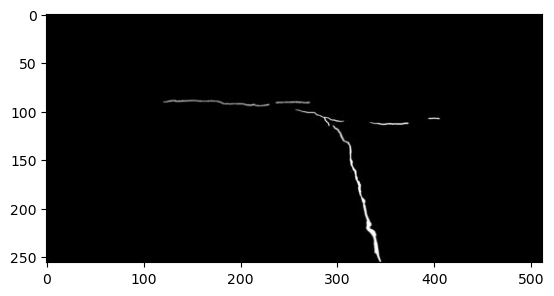

In [6]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [7]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 213 0 255


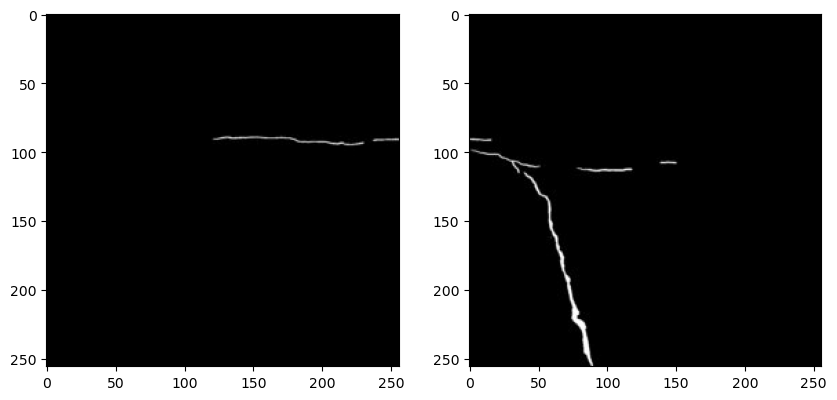

In [8]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

In [9]:
"""
color_set = set()
for train_fn in tqdm(train_fns[:10]):
    train_fp = os.path.join(train_dir, train_fn)
    image = np.array(Image.open(train_fp))
    cityscape, label = split_image(sample_image)
    label = label.reshape(-1, 3)
    local_color_set = set([tuple(c) for c in list(label)])
    color_set.update(local_color_set)
color_array = np.array(list(color_set))
"""

num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[150  16 103]
 [242 104 125]
 [ 85 202 143]
 [134  74  31]
 [ 45 147 210]]


In [10]:
num_classes = 2
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

C:\Users\tamim\anaconda3\envs\DeepCrack\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

In [11]:
label_model.predict(color_array[:5, :])

array([0, 1, 1, 0, 1])

In [12]:
class Dataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        data, label = self.split_image(image) ## Tamim: changed the name from cityscape to data
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        data = self.transform(data) ## Tamim: changed the name from cityscape to data
        label_class = torch.Tensor(label_class).long()
        return data, label_class ## Tamim: changed the name from  cityscape to data
    
    def split_image(self, image):
        image = np.array(image)
        data, label = image[:, :256, :], image[:, 256:, :] ## Tamim: changed the name from cityscape to data
        return data, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [13]:
dataset = Dataset(train_dir, label_model)
print(len(dataset))

10


In [14]:
data, label_class = dataset[0] ## Tamim: changed the name from cityscape to data
print(data.shape, label_class.shape) ## Tamim: changed the name from cityscape to data

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [17]:
from torch import nn
import torch
import torch.nn.functional as F


def Conv3X3(in_, out):
    return torch.nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = Conv3X3(in_, out)
        self.activation = torch.nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class Down(nn.Module):

    def __init__(self, nn):
        super(Down,self).__init__()
        self.nn = nn
        self.maxpool_with_argmax = torch.nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self,inputs):
        down = self.nn(inputs)
        unpooled_shape = down.size()
        outputs, indices = self.maxpool_with_argmax(down)
        return outputs, down, indices, unpooled_shape

class Up(nn.Module):

    def __init__(self, nn):
        super().__init__()
        self.nn = nn
        self.unpool=torch.nn.MaxUnpool2d(2,2)

    def forward(self,inputs,indices,output_shape):
        outputs = self.unpool(inputs, indices=indices, output_size=output_shape)
        outputs = self.nn(outputs)
        return outputs

class Fuse(nn.Module):

    def __init__(self, nn, scale):
        super().__init__()
        self.nn = nn
        self.scale = scale
        self.conv = Conv3X3(64,1)

    def forward(self,down_inp,up_inp):
        outputs = torch.cat([down_inp, up_inp], 1)
        outputs = F.interpolate(outputs, scale_factor=self.scale, mode='bilinear')
        outputs = self.nn(outputs)

        return self.conv(outputs)



class DeepCrack(nn.Module):

    def __init__(self, num_classes=1000):
        super(DeepCrack, self).__init__()

        self.down1 = Down(torch.nn.Sequential(
            ConvRelu(3,64),
            ConvRelu(64,64),
        ))

        self.down2 = Down(torch.nn.Sequential(
            ConvRelu(64,128),
            ConvRelu(128,128),
        ))

        self.down3 = Down(torch.nn.Sequential(
            ConvRelu(128,256),
            ConvRelu(256,256),
            ConvRelu(256,256),
        ))

        self.down4 = Down(torch.nn.Sequential(
            ConvRelu(256, 512),
            ConvRelu(512, 512),
            ConvRelu(512, 512),
        ))

        self.down5 = Down(torch.nn.Sequential(
            ConvRelu(512, 512),
            ConvRelu(512, 512),
            ConvRelu(512, 512),
        ))

        self.up1 = Up(torch.nn.Sequential(
            ConvRelu(64, 64),
            ConvRelu(64, 64),
        ))

        self.up2 = Up(torch.nn.Sequential(
            ConvRelu(128, 128),
            ConvRelu(128, 64),
        ))

        self.up3 = Up(torch.nn.Sequential(
            ConvRelu(256, 256),
            ConvRelu(256, 256),
            ConvRelu(256, 128),
        ))

        self.up4 = Up(torch.nn.Sequential(
            ConvRelu(512, 512),
            ConvRelu(512, 512),
            ConvRelu(512, 256),
        ))

        self.up5 = Up(torch.nn.Sequential(
            ConvRelu(512, 512),
            ConvRelu(512, 512),
            ConvRelu(512, 512),
        ))

        self.fuse5 = Fuse(ConvRelu(512 + 512, 64), scale=16)
        self.fuse4 = Fuse(ConvRelu(512 + 256, 64), scale=8)
        self.fuse3 = Fuse(ConvRelu(256 + 128, 64), scale=4)
        self.fuse2 = Fuse(ConvRelu(128 + 64, 64), scale=2)
        self.fuse1 = Fuse(ConvRelu(64 + 64, 64), scale=1)

        self.final = Conv3X3(5,1)

    def forward(self,inputs):

        # encoder part
        out, down1, indices_1, unpool_shape1 = self.down1(inputs)
        out, down2, indices_2, unpool_shape2 = self.down2(out)
        out, down3, indices_3, unpool_shape3 = self.down3(out)
        out, down4, indices_4, unpool_shape4 = self.down4(out)
        out, down5, indices_5, unpool_shape5 = self.down5(out)

        # decoder part
        up5 = self.up5(out, indices=indices_5, output_shape=unpool_shape5)
        up4 = self.up4(up5, indices=indices_4, output_shape=unpool_shape4)
        up3 = self.up3(up4, indices=indices_3, output_shape=unpool_shape3)
        up2 = self.up2(up3, indices=indices_2, output_shape=unpool_shape2)
        up1 = self.up1(up2, indices=indices_1, output_shape=unpool_shape1)

        fuse5 = self.fuse5(down_inp=down5,up_inp=up5)
        fuse4 = self.fuse4(down_inp=down4, up_inp=up4)
        fuse3 = self.fuse3(down_inp=down3, up_inp=up3)
        fuse2 = self.fuse2(down_inp=down2, up_inp=up2)
        fuse1 = self.fuse1(down_inp=down1, up_inp=up1)

        output = self.final(torch.cat([fuse5,fuse4,fuse3,fuse2,fuse1],1))

        return output, fuse5, fuse4, fuse3, fuse2, fuse1

if __name__ == '__main__':
    inp = torch.randn((1,3,512,512))

    model = DeepCrack()

    out = model(inp)

In [18]:
model = model(num_classes=num_classes)

TypeError: DeepCrack.forward() got an unexpected keyword argument 'num_classes'

In [ ]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape, Y.shape)

In [ ]:
Y_pred = model(X)
print(Y_pred.shape)

In [ ]:
batch_size = 16

epochs = 10
lr = 0.01

In [70]:
dataset = Dataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [71]:
model = UNet(num_classes=num_classes).to(device)

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [73]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

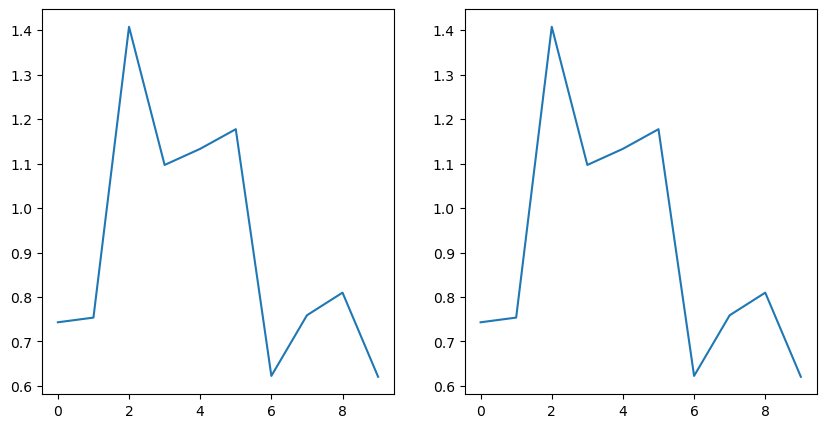

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [75]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

In [76]:
model_path = "/kaggle/working/U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)

In [77]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [78]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 2, 256, 256])
torch.Size([8, 256, 256])


In [79]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

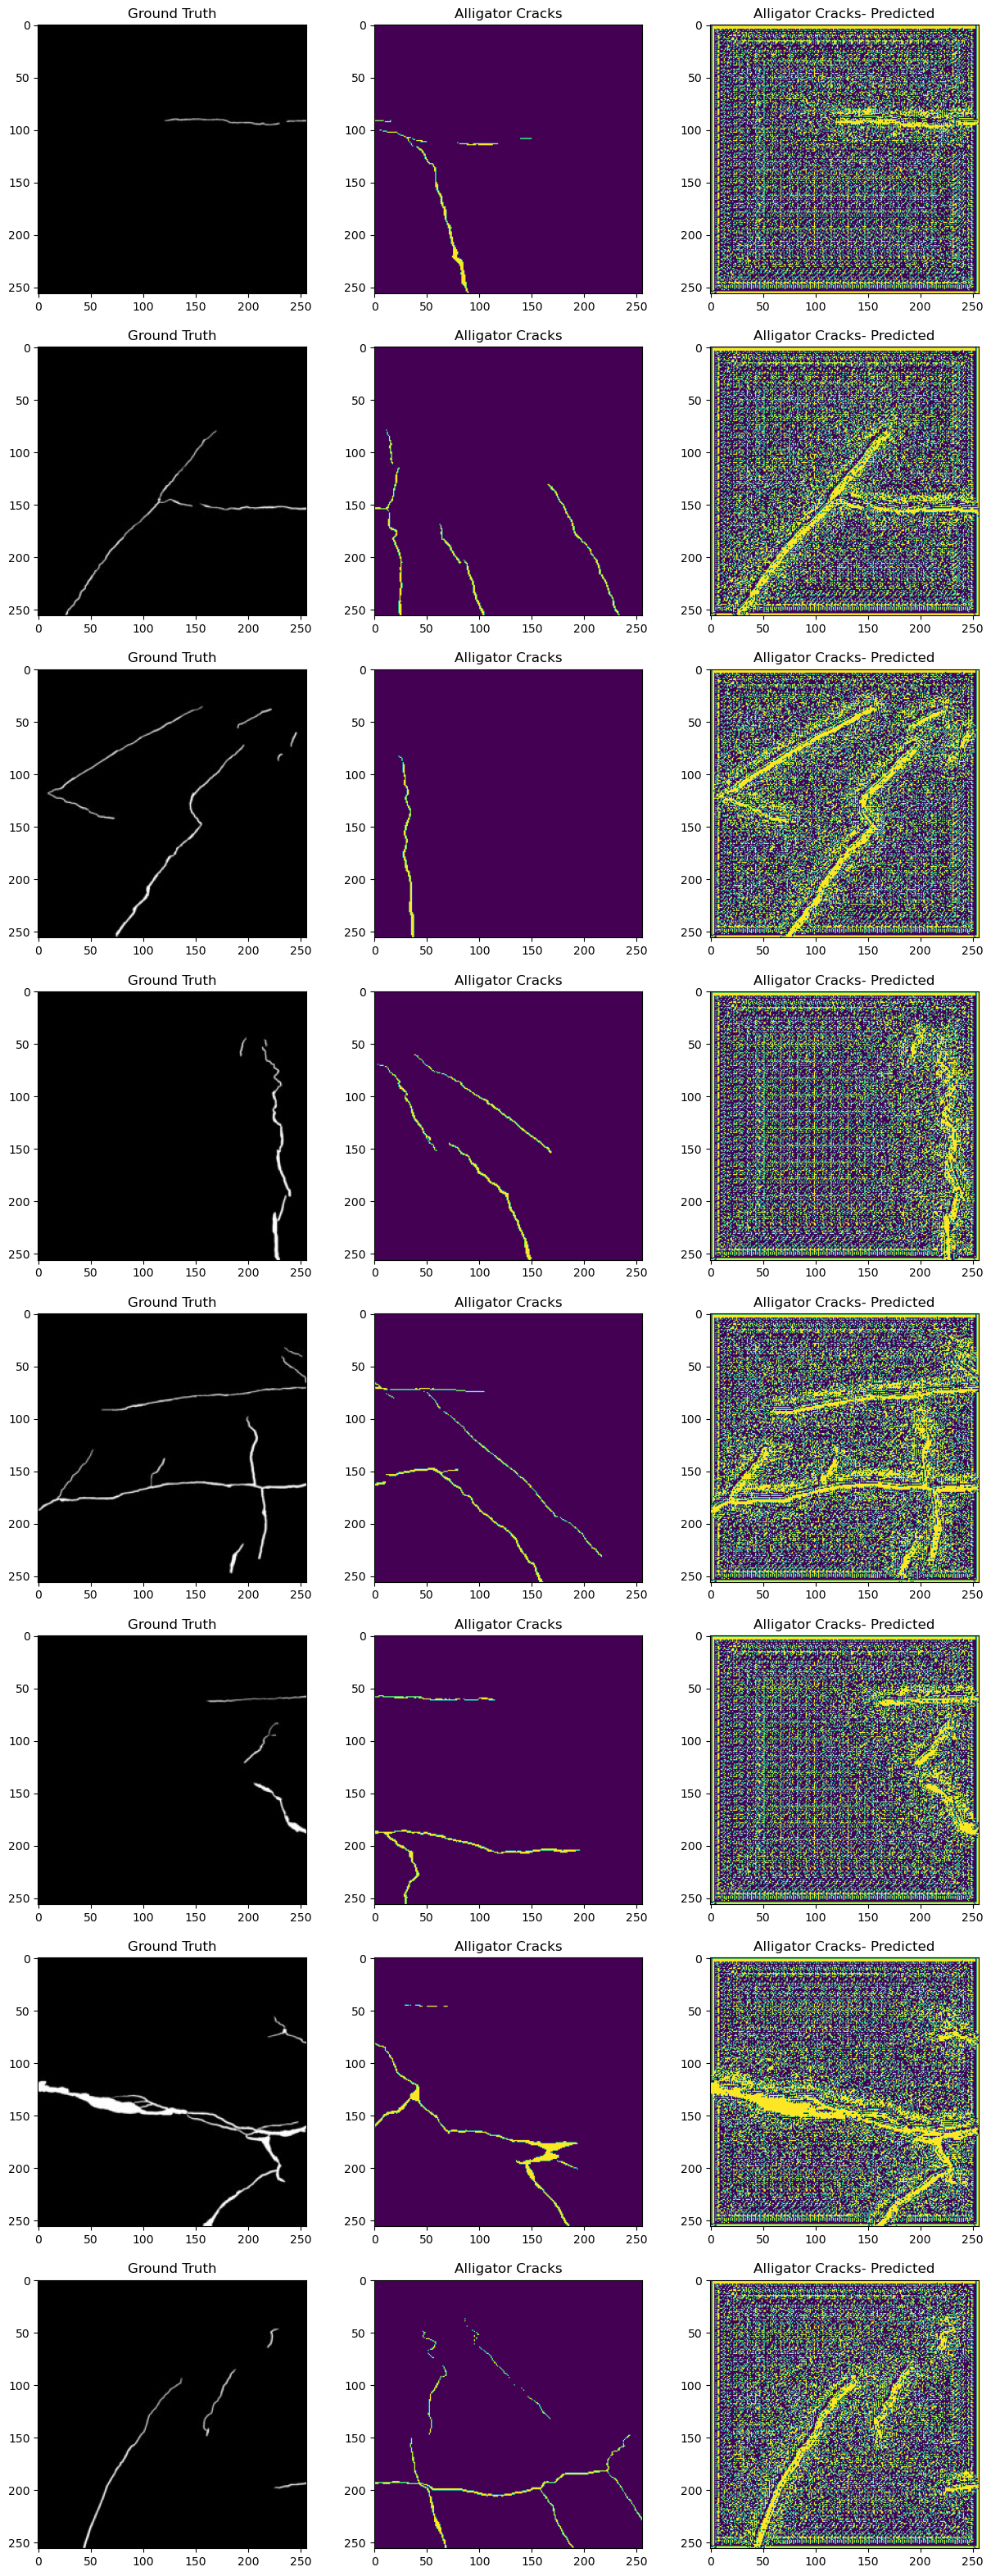

In [80]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Ground Truth")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Alligator Cracks")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Alligator Cracks- Predicted")
